In [26]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, Model
import matplotlib.pyplot as plt 
import seaborn as sns
import os
import math
import glob
import pandas as pd
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import re

In [28]:
# % Used Smartphone: LGE-lge-LG-H815-5.1                                             
# % Smartphone's Accelerometer: LGE Accelerometer - Vendor: BOSCH                    
# % --> Version: 1                                                                   
# % --> Min - Max Delay: 5000us - 65535000us                                         
# % --> Maximum Range: 16.000000263891405 G                                          
# % --> Resolution: 1.2136514986004396E-4 G                                          
                                                                                    
# % SensorTag's Accelerometer: MPU-9250 MEMS MotionTracking Device - Invensense      
# % --> Maximum Range: 16 G                                                          
# % --> Resolution: 0.00024 G                                                        
                                                                                    
# % MAC Address; Sensor_ID; Position; Device Model                                   
# %f8:95:c7:f3:ba:82; 0; RIGHTPOCKET; lge-LG-H815-5.1                                
# %C4:BE:84:70:64:8A; 1; CHEST; SensorTag                                            
# %C4:BE:84:70:0E:80; 3; WRIST; SensorTag                                            
# %C4:BE:84:71:A5:02; 2; WAIST; SensorTag                                            
# %B0:B4:48:B8:77:03; 4; ANKLE; SensorTag                                            
                                                                                    
# % Sensor_Type:                                                                     
# % Accelerometer = 0                                                                
# % Gyroscope = 1                                                                    
# % Magnetometer = 2  

In [29]:
datapath = "../CAGE/data/UMAFall_Dataset/"
all_files = glob.glob(os.path.join(datapath, "*.csv"))

In [30]:
def parse_filename(filename):
    pattern = r'UMAFall_Subject_(\d+)_(ADL|Fall)_([a-zA-Z_]+)_(\d+)_(\d{4}-\d{2}-\d{2})_.*\.csv'
    match = re.match(pattern, filename)
    
    if match:
        subject_id = int(match.group(1))
        activity_type = match.group(2)
        activity = match.group(3)
        trial = int(match.group(4))
        date = match.group(5)
        return subject_id, activity_type, activity, trial, date
    return None

In [31]:
def read_all_sensors_file(filepath):
    sensor_data = {
        'RIGHTPOCKET': {'id': None, 'data': []},
        'CHEST': {'id': None, 'data': []},
        'WRIST': {'id': None, 'data': []},
        'WAIST': {'id': None, 'data': []},
        'ANKLE': {'id': None, 'data': []}
    }
    
    with open(filepath, 'r') as f:
        lines = f.readlines()
        for line in lines:
            if ';' in line and any(pos in line for pos in sensor_data.keys()):
                parts = line.strip().split(';')
                if len(parts) >= 3:
                    sensor_id = parts[1].strip()
                    position = parts[2].strip()
                    if position in sensor_data:
                        sensor_data[position]['id'] = sensor_id
        
        data_start = False
        for line in lines:
            if '% TimeStamp; Sample No;' in line:
                data_start = True
                continue
            
            if data_start:
                try:
                    values = [float(v.strip()) for v in line.split(';')]
                    sensor_id = str(int(values[-1]))
                    sensor_type = int(values[-2])
                    data = values[2:5]
                    
                    for position, info in sensor_data.items():
                        if info['id'] == sensor_id:
                            info['data'].append([*data, sensor_type])
                except:
                    continue
    
    for position in sensor_data:
        if sensor_data[position]['data']:
            sensor_data[position]['data'] = np.array(sensor_data[position]['data'])
        else:
            sensor_data[position]['data'] = None
            
    return sensor_data

In [32]:
def process_sensor_data(sensor_data):
    processed_data = {}
    valid_lengths = []
    
    for position, data in sensor_data.items():
        if data['data'] is not None:
            acc_mask = data['data'][:, -1] == 0
            gyro_mask = data['data'][:, -1] == 1
            mag_mask = data['data'][:, -1] == 2
            
            acc_data = data['data'][acc_mask][:, :3] if np.any(acc_mask) else np.array([])
            gyro_data = data['data'][gyro_mask][:, :3] if np.any(gyro_mask) else np.array([])
            mag_data = data['data'][mag_mask][:, :3] if np.any(mag_mask) else np.array([])
            
            if len(acc_data) > 0:
                valid_lengths.append(len(acc_data))
            if len(gyro_data) > 0:
                valid_lengths.append(len(gyro_data))
            if len(mag_data) > 0:
                valid_lengths.append(len(mag_data))
    
    if not valid_lengths:
        return None
        
    min_length = min(valid_lengths)
    
    for position, data in sensor_data.items():
        if data['data'] is not None:
            acc_mask = data['data'][:, -1] == 0
            gyro_mask = data['data'][:, -1] == 1
            mag_mask = data['data'][:, -1] == 2
            
            if np.any(acc_mask):
                acc_data = data['data'][acc_mask][:min_length, :3]
                acc_cols = [f'{position.lower()}_acc_x', f'{position.lower()}_acc_y', f'{position.lower()}_acc_z']
                processed_data.update(dict(zip(acc_cols, acc_data.T)))
            
            if np.any(gyro_mask):
                gyro_data = data['data'][gyro_mask][:min_length, :3]
                gyro_cols = [f'{position.lower()}_gyro_x', f'{position.lower()}_gyro_y', f'{position.lower()}_gyro_z']
                processed_data.update(dict(zip(gyro_cols, gyro_data.T)))
            
            if np.any(mag_mask):
                mag_data = data['data'][mag_mask][:min_length, :3]
                mag_cols = [f'{position.lower()}_mag_x', f'{position.lower()}_mag_y', f'{position.lower()}_mag_z']
                processed_data.update(dict(zip(mag_cols, mag_data.T)))
    
    if not processed_data:
        return None
        
    return pd.DataFrame(processed_data)

In [33]:
subject_id = 18
dfs = []

In [34]:
for file in tqdm(all_files):
    filename = os.path.basename(file)
    info = parse_filename(filename)
    
    if info and info[0] == subject_id:
        sensor_data = read_all_sensors_file(file)
        df = process_sensor_data(sensor_data)
        
        if df is not None:
            df['subject'] = info[0]
            df['activity'] = info[2]  
            df['trial'] = info[3]
            dfs.append(df)

100%|████████████████████████████████████████| 746/746 [00:05<00:00, 138.38it/s]


In [35]:
features = pd.concat(dfs, ignore_index=True)
print ("shape : ", features.shape)
sensor_columns = [col for col in features.columns if any(x in col for x in ['acc', 'gyro', 'mag'])]
print ("columns :", end=' ')
print (sensor_columns)

print ()
features = pd.concat(dfs, ignore_index=True)
print("Columns after concat:", features.columns)
print("\nActivity distribution :", features['activity'].value_counts())

shape :  (56241, 42)
columns : ['rightpocket_acc_x', 'rightpocket_acc_y', 'rightpocket_acc_z', 'chest_acc_x', 'chest_acc_y', 'chest_acc_z', 'chest_gyro_x', 'chest_gyro_y', 'chest_gyro_z', 'chest_mag_x', 'chest_mag_y', 'chest_mag_z', 'wrist_acc_x', 'wrist_acc_y', 'wrist_acc_z', 'wrist_gyro_x', 'wrist_gyro_y', 'wrist_gyro_z', 'wrist_mag_x', 'wrist_mag_y', 'wrist_mag_z', 'waist_acc_x', 'waist_acc_y', 'waist_acc_z', 'waist_gyro_x', 'waist_gyro_y', 'waist_gyro_z', 'waist_mag_x', 'waist_mag_y', 'waist_mag_z', 'ankle_acc_x', 'ankle_acc_y', 'ankle_acc_z', 'ankle_gyro_x', 'ankle_gyro_y', 'ankle_gyro_z', 'ankle_mag_x', 'ankle_mag_y', 'ankle_mag_z']

Columns after concat: Index(['rightpocket_acc_x', 'rightpocket_acc_y', 'rightpocket_acc_z',
       'chest_acc_x', 'chest_acc_y', 'chest_acc_z', 'chest_gyro_x',
       'chest_gyro_y', 'chest_gyro_z', 'chest_mag_x', 'chest_mag_y',
       'chest_mag_z', 'wrist_acc_x', 'wrist_acc_y', 'wrist_acc_z',
       'wrist_gyro_x', 'wrist_gyro_y', 'wrist_gyro_z', '

In [36]:
features['activity'] = features['activity'].map(
    lambda x: 1 if x in ['forwardFall', 'backwardFall', 'lateralFall'] else 0
)
print("\nActivity distribution :", features['activity'].value_counts())


Activity distribution : activity
0    39567
1    16674
Name: count, dtype: int64


In [37]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56241 entries, 0 to 56240
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rightpocket_acc_x  56241 non-null  float64
 1   rightpocket_acc_y  56241 non-null  float64
 2   rightpocket_acc_z  56241 non-null  float64
 3   chest_acc_x        56241 non-null  float64
 4   chest_acc_y        56241 non-null  float64
 5   chest_acc_z        56241 non-null  float64
 6   chest_gyro_x       56241 non-null  float64
 7   chest_gyro_y       56241 non-null  float64
 8   chest_gyro_z       56241 non-null  float64
 9   chest_mag_x        56241 non-null  float64
 10  chest_mag_y        56241 non-null  float64
 11  chest_mag_z        56241 non-null  float64
 12  wrist_acc_x        56241 non-null  float64
 13  wrist_acc_y        56241 non-null  float64
 14  wrist_acc_z        56241 non-null  float64
 15  wrist_gyro_x       56241 non-null  float64
 16  wrist_gyro_y       562

In [38]:
features = features.dropna()
features.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22403 entries, 0 to 55944
Data columns (total 42 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rightpocket_acc_x  22403 non-null  float64
 1   rightpocket_acc_y  22403 non-null  float64
 2   rightpocket_acc_z  22403 non-null  float64
 3   chest_acc_x        22403 non-null  float64
 4   chest_acc_y        22403 non-null  float64
 5   chest_acc_z        22403 non-null  float64
 6   chest_gyro_x       22403 non-null  float64
 7   chest_gyro_y       22403 non-null  float64
 8   chest_gyro_z       22403 non-null  float64
 9   chest_mag_x        22403 non-null  float64
 10  chest_mag_y        22403 non-null  float64
 11  chest_mag_z        22403 non-null  float64
 12  wrist_acc_x        22403 non-null  float64
 13  wrist_acc_y        22403 non-null  float64
 14  wrist_acc_z        22403 non-null  float64
 15  wrist_gyro_x       22403 non-null  float64
 16  wrist_gyro_y       22403 no

In [39]:
sensor_columns = [col for col in features.columns if any(x in col for x in ['acc', 'gyro', 'mag'])]

scaler = StandardScaler()
features_scaled = features.copy()
features_scaled[sensor_columns] = scaler.fit_transform(features[sensor_columns])

features_scaled = features_scaled[sensor_columns + ['activity']]
features_scaled.columns

Index(['rightpocket_acc_x', 'rightpocket_acc_y', 'rightpocket_acc_z',
       'chest_acc_x', 'chest_acc_y', 'chest_acc_z', 'chest_gyro_x',
       'chest_gyro_y', 'chest_gyro_z', 'chest_mag_x', 'chest_mag_y',
       'chest_mag_z', 'wrist_acc_x', 'wrist_acc_y', 'wrist_acc_z',
       'wrist_gyro_x', 'wrist_gyro_y', 'wrist_gyro_z', 'wrist_mag_x',
       'wrist_mag_y', 'wrist_mag_z', 'waist_acc_x', 'waist_acc_y',
       'waist_acc_z', 'waist_gyro_x', 'waist_gyro_y', 'waist_gyro_z',
       'waist_mag_x', 'waist_mag_y', 'waist_mag_z', 'ankle_acc_x',
       'ankle_acc_y', 'ankle_acc_z', 'ankle_gyro_x', 'ankle_gyro_y',
       'ankle_gyro_z', 'ankle_mag_x', 'ankle_mag_y', 'ankle_mag_z',
       'activity'],
      dtype='object')

In [40]:
def split_sequences(sequences, n_steps, stride):
    X, y = [], []
    for i in range(0, len(sequences) - n_steps + 1, stride):
        end_ix = i + n_steps
        
        seq_x = sequences.iloc[i:end_ix].iloc[:, :-1]  
        seq_y = sequences.iloc[end_ix-1].iloc[-1]      
        
        X.append(seq_x.values)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [41]:
adl_count = features_scaled['activity'].value_counts()[0]
fall_count = features_scaled['activity'].value_counts()[1]

adl_mask = features_scaled['activity'] == 0
adl_data = features_scaled[adl_mask]
adl1 = adl_data.iloc[:int(adl_count * 0.8)]    # 80% for training
adl2 = adl_data.iloc[int(adl_count * 0.2):]    # 20% for testing

fall_mask = features_scaled['activity'] == 1
fall_data = features_scaled[fall_mask]
fall1 = fall_data.iloc[:int(fall_count * 0.8)]  # 80% for testing
fall2 = fall_data.iloc[int(fall_count * 0.2):]  # 20% for testing

print(f"ADL1 (train) shape: {adl1.shape}")
print(f"ADL2 (test) shape: {adl2.shape}")
print(f"Fall1 (test) shape: {fall1.shape}")
print(f"Fall2 (test) shape: {fall2.shape}")

ADL1 (train) shape: (16486, 40)
ADL2 (test) shape: (16487, 40)
Fall1 (test) shape: (1436, 40)
Fall2 (test) shape: (1436, 40)


In [42]:
WINDOW_LENGTH = 40
STRIDE = 20

train_data, train_labels = split_sequences(adl1, WINDOW_LENGTH, STRIDE)

test_adl_data, test_adl_labels = split_sequences(adl2, WINDOW_LENGTH, STRIDE)
test_fall1_data, test_fall1_labels = split_sequences(fall1, WINDOW_LENGTH, STRIDE)
test_fall2_data, test_fall2_labels = split_sequences(fall2, WINDOW_LENGTH, STRIDE)

test_data = np.concatenate([test_adl_data, test_fall1_data, test_fall2_data])
test_labels = np.concatenate([test_adl_labels, test_fall1_labels, test_fall2_labels])

print(f"Train data: {train_data.shape}")
print(f"Train labels: {train_labels.shape}")
print(f"Test data: {test_data.shape}")
print(f"Test labels: {test_labels.shape}")

Train data: (823, 40, 39)
Train labels: (823,)
Test data: (963, 40, 39)
Test labels: (963,)


----

In [43]:
EPOCHS = 300
INITIAL_LEARNING_RATE = 1e-3  
DECAY_STEPS = 1000  
DECAY_RATE = 0.98  
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 32

In [44]:
class UMAFallDataset(Dataset):
    def __init__(self, data):
        # Transpose data from [batch, window_length, features] to [batch, features, window_length]
        data = data.transpose(0, 2, 1)
        self.data = torch.FloatTensor(data)
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx]  # Returns shape [features, window_length]

In [45]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels, out_channels, kernel_size=3, padding='same'),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels, kernel_size=3, padding='same'),
            nn.ReLU()
        )

    def forward(self, x):
        return self.conv(x)

In [46]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

In [47]:
class UNet1D(nn.Module):
    def __init__(self, in_channels=39):
        super(UNet1D, self).__init__()
        
        # Sinusoidal time embeddings
        self.time_embed = nn.Sequential(
            SinusoidalPositionEmbeddings(32),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 64)
        )
        
        # Encoder
        self.enc1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool1d(2, padding=0)
        
        self.enc2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool1d(2, padding=0)
        
        self.enc3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool1d(2, padding=0)
        
        # Bottleneck
        self.bottleneck = DoubleConv(256, 512)
        
        # Time feature projection
        self.time_mlp = nn.Linear(64, 512)
        
        # Decoder with output padding to match encoder sizes
        self.upconv3 = nn.ConvTranspose1d(512, 256, 2, stride=2, output_padding=0)
        self.dec3 = DoubleConv(512, 256)
        
        self.upconv2 = nn.ConvTranspose1d(256, 128, 2, stride=2, output_padding=0)
        self.dec2 = DoubleConv(256, 128)
        
        self.upconv1 = nn.ConvTranspose1d(128, 64, 2, stride=2, output_padding=0)
        self.dec1 = DoubleConv(128, 64)
        
        self.final_conv = nn.Conv1d(64, in_channels, 1)
        
    def forward(self, x, t):
        # Time embedding
        t_emb = self.time_embed(t)
        t_emb = self.time_mlp(t_emb)
        
        # Encoder
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        
        e3 = self.enc3(p2)
        p3 = self.pool3(e3)
        
        # Bottleneck with time embedding
        b = self.bottleneck(p3)
        b = b + t_emb.unsqueeze(-1)
        
        # Decoder with size adjustment if needed
        d3 = self.upconv3(b)
        if d3.shape[-1] != e3.shape[-1]:
            d3 = F.interpolate(d3, size=e3.shape[-1], mode='linear')
        d3 = torch.cat([d3, e3], dim=1)
        d3 = self.dec3(d3)
        
        d2 = self.upconv2(d3)
        if d2.shape[-1] != e2.shape[-1]:
            d2 = F.interpolate(d2, size=e2.shape[-1], mode='linear')
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)
        
        d1 = self.upconv1(d2)
        if d1.shape[-1] != e1.shape[-1]:
            d1 = F.interpolate(d1, size=e1.shape[-1], mode='linear')
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)
        
        return self.final_conv(d1)

In [48]:
class DDPM:
    def __init__(self, num_timesteps=100, beta_start=1e-4, beta_end=0.02):
        """
        num_timesteps: total diffusion steps T
        beta_start, beta_end: β₁ and βₜ for linear schedule
        """
        self.num_timesteps = num_timesteps
        
        # Linear variance schedule
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.alphas = 1. - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)
        
    def q_sample(self, x_0, t):
        """
        Forward diffusion process: q(x_t | x_0)
        Samples from q(x_t | x_0) = N(x_t; √(αₜ)x₀, (1-αₜ)I)
        """
        sqrt_alphas_cumprod = torch.sqrt(self.alphas_cumprod[t])[:, None, None]
        sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - self.alphas_cumprod[t])[:, None, None]
        epsilon = torch.randn_like(x_0)
        return sqrt_alphas_cumprod * x_0 + sqrt_one_minus_alphas_cumprod * epsilon, epsilon
    
    def sample_t(self, batch_size):
        """
        Uniformly sample timesteps t
        """
        return torch.randint(0, self.num_timesteps, (batch_size,))
        
    def p_sample(self, model, batch_size, device, shape):
        """
        Reverse diffusion process: p_θ(x_{t-1} | x_t)
        Generate samples using the reverse process
        """
        model.eval()
        with torch.no_grad():
            x_t = torch.randn(batch_size, *shape).to(device)
            
            for t in reversed(range(1, self.num_timesteps)):
                time_tensor = torch.ones(batch_size, dtype=torch.long).to(device) * t
                
                # Predict noise
                predicted_noise = model(x_t, time_tensor)
                
                alpha = self.alphas[t][:, None, None]
                alpha_cumprod = self.alphas_cumprod[t][:, None, None]
                beta = self.betas[t][:, None, None]
                
                # Add noise for stochasticity
                noise = torch.randn_like(x_t)
                
                # Compute mean for p_θ(x_{t-1} | x_t)
                x_t = 1 / torch.sqrt(alpha) * (
                    x_t - (1 - alpha) / torch.sqrt(1 - alpha_cumprod) * predicted_noise
                ) + torch.sqrt(beta) * noise
                
        model.train()
        return x_t

In [49]:
def train_ddpm(model, train_loader, ddpm, optimizer, num_epochs, device):
    model.train()
    
    for epoch in range(num_epochs):
        epoch_loss = 0
        n_batches = len(train_loader)
        
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            # batch is already [batch, features, window_length]
            x_0 = batch.to(device)
            batch_size = x_0.shape[0]
            
            optimizer.zero_grad()
            t = ddpm.sample_t(batch_size).to(device)
            x_t, epsilon = ddpm.q_sample(x_0, t)
            epsilon_theta = model(x_t, t)
            loss = F.mse_loss(epsilon_theta, epsilon)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()
        
        avg_loss = epoch_loss / n_batches
        print(f'Epoch {epoch+1}/{num_epochs} - Avg Loss: {avg_loss:.4f}')

In [50]:
model = UNet1D().to(device)
ddpm = DDPM(num_timesteps=1000)  
optimizer = optim.Adam(model.parameters(), lr=2e-4)  

print("Train data shape:", train_data.shape)

train_dataset = UMAFallDataset(train_data)
sample_data = train_dataset[0]
print("Dataset sample shape:", sample_data.shape)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
first_batch = next(iter(train_loader))
print("Batch shape:", first_batch.shape)

train_ddpm(
    model=model,
    train_loader=train_loader,
    ddpm=ddpm,
    optimizer=optimizer,
    num_epochs=EPOCHS,
    device=device    
)

Train data shape: (823, 40, 39)
Dataset sample shape: torch.Size([39, 40])
Batch shape: torch.Size([32, 39, 40])


Epoch 1/300: 100%|██████████████████████████████| 26/26 [00:01<00:00, 13.26it/s]


Epoch 1/300 - Avg Loss: 1.0041


Epoch 2/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 10.85it/s]


Epoch 2/300 - Avg Loss: 0.9957


Epoch 3/300: 100%|██████████████████████████████| 26/26 [00:02<00:00, 10.49it/s]


Epoch 3/300 - Avg Loss: 0.9791


Epoch 4/300: 100%|██████████████████████████████| 26/26 [00:02<00:00,  9.34it/s]


Epoch 4/300 - Avg Loss: 0.9491


Epoch 5/300: 100%|██████████████████████████████| 26/26 [00:02<00:00,  9.10it/s]


Epoch 5/300 - Avg Loss: 0.9156


Epoch 6/300: 100%|██████████████████████████████| 26/26 [00:02<00:00,  9.16it/s]


Epoch 6/300 - Avg Loss: 0.8864


Epoch 7/300: 100%|██████████████████████████████| 26/26 [00:02<00:00,  9.14it/s]


Epoch 7/300 - Avg Loss: 0.8615


Epoch 8/300: 100%|██████████████████████████████| 26/26 [00:02<00:00,  8.95it/s]


Epoch 8/300 - Avg Loss: 0.8426


Epoch 9/300: 100%|██████████████████████████████| 26/26 [00:02<00:00,  9.28it/s]


Epoch 9/300 - Avg Loss: 0.8231


Epoch 10/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  9.35it/s]


Epoch 10/300 - Avg Loss: 0.8100


Epoch 11/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  9.29it/s]


Epoch 11/300 - Avg Loss: 0.7960


Epoch 12/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  9.47it/s]


Epoch 12/300 - Avg Loss: 0.7794


Epoch 13/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  9.37it/s]


Epoch 13/300 - Avg Loss: 0.7680


Epoch 14/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  9.52it/s]


Epoch 14/300 - Avg Loss: 0.7547


Epoch 15/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  9.36it/s]


Epoch 15/300 - Avg Loss: 0.7524


Epoch 16/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  9.46it/s]


Epoch 16/300 - Avg Loss: 0.7381


Epoch 17/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  9.59it/s]


Epoch 17/300 - Avg Loss: 0.7331


Epoch 18/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.00it/s]


Epoch 18/300 - Avg Loss: 0.7193


Epoch 19/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  9.10it/s]


Epoch 19/300 - Avg Loss: 0.7108


Epoch 20/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  9.31it/s]


Epoch 20/300 - Avg Loss: 0.7133


Epoch 21/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  9.10it/s]


Epoch 21/300 - Avg Loss: 0.7003


Epoch 22/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  9.23it/s]


Epoch 22/300 - Avg Loss: 0.6883


Epoch 23/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  9.24it/s]


Epoch 23/300 - Avg Loss: 0.6831


Epoch 24/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  9.27it/s]


Epoch 24/300 - Avg Loss: 0.6777


Epoch 25/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.92it/s]


Epoch 25/300 - Avg Loss: 0.6596


Epoch 26/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  7.99it/s]


Epoch 26/300 - Avg Loss: 0.6694


Epoch 27/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  7.67it/s]


Epoch 27/300 - Avg Loss: 0.6616


Epoch 28/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  7.72it/s]


Epoch 28/300 - Avg Loss: 0.6576


Epoch 29/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.95it/s]


Epoch 29/300 - Avg Loss: 0.6537


Epoch 30/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  9.23it/s]


Epoch 30/300 - Avg Loss: 0.6413


Epoch 31/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  9.18it/s]


Epoch 31/300 - Avg Loss: 0.6379


Epoch 32/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  9.03it/s]


Epoch 32/300 - Avg Loss: 0.6308


Epoch 33/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  9.01it/s]


Epoch 33/300 - Avg Loss: 0.6217


Epoch 34/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.92it/s]


Epoch 34/300 - Avg Loss: 0.6279


Epoch 35/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  7.95it/s]


Epoch 35/300 - Avg Loss: 0.6168


Epoch 36/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  7.55it/s]


Epoch 36/300 - Avg Loss: 0.6030


Epoch 37/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  7.38it/s]


Epoch 37/300 - Avg Loss: 0.6069


Epoch 38/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  7.24it/s]


Epoch 38/300 - Avg Loss: 0.6120


Epoch 39/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  9.11it/s]


Epoch 39/300 - Avg Loss: 0.6152


Epoch 40/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  9.09it/s]


Epoch 40/300 - Avg Loss: 0.5981


Epoch 41/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.71it/s]


Epoch 41/300 - Avg Loss: 0.5932


Epoch 42/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.78it/s]


Epoch 42/300 - Avg Loss: 0.5886


Epoch 43/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  9.11it/s]


Epoch 43/300 - Avg Loss: 0.5806


Epoch 44/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  9.00it/s]


Epoch 44/300 - Avg Loss: 0.5799


Epoch 45/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  9.04it/s]


Epoch 45/300 - Avg Loss: 0.5794


Epoch 46/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.96it/s]


Epoch 46/300 - Avg Loss: 0.5763


Epoch 47/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.95it/s]


Epoch 47/300 - Avg Loss: 0.5843


Epoch 48/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.89it/s]


Epoch 48/300 - Avg Loss: 0.5714


Epoch 49/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.65it/s]


Epoch 49/300 - Avg Loss: 0.5599


Epoch 50/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.63it/s]


Epoch 50/300 - Avg Loss: 0.5630


Epoch 51/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  9.00it/s]


Epoch 51/300 - Avg Loss: 0.5495


Epoch 52/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.97it/s]


Epoch 52/300 - Avg Loss: 0.5581


Epoch 53/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.80it/s]


Epoch 53/300 - Avg Loss: 0.5611


Epoch 54/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.19it/s]


Epoch 54/300 - Avg Loss: 0.5538


Epoch 55/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.88it/s]


Epoch 55/300 - Avg Loss: 0.5488


Epoch 56/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.64it/s]


Epoch 56/300 - Avg Loss: 0.5407


Epoch 57/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.87it/s]


Epoch 57/300 - Avg Loss: 0.5423


Epoch 58/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  7.58it/s]


Epoch 58/300 - Avg Loss: 0.5326


Epoch 59/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.94it/s]


Epoch 59/300 - Avg Loss: 0.5368


Epoch 60/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.58it/s]


Epoch 60/300 - Avg Loss: 0.5288


Epoch 61/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.52it/s]


Epoch 61/300 - Avg Loss: 0.5266


Epoch 62/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.86it/s]


Epoch 62/300 - Avg Loss: 0.5227


Epoch 63/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.77it/s]


Epoch 63/300 - Avg Loss: 0.5272


Epoch 64/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.87it/s]


Epoch 64/300 - Avg Loss: 0.5208


Epoch 65/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.85it/s]


Epoch 65/300 - Avg Loss: 0.5224


Epoch 66/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.78it/s]


Epoch 66/300 - Avg Loss: 0.5262


Epoch 67/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.83it/s]


Epoch 67/300 - Avg Loss: 0.5158


Epoch 68/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.77it/s]


Epoch 68/300 - Avg Loss: 0.5065


Epoch 69/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.76it/s]


Epoch 69/300 - Avg Loss: 0.5178


Epoch 70/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.89it/s]


Epoch 70/300 - Avg Loss: 0.5041


Epoch 71/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.86it/s]


Epoch 71/300 - Avg Loss: 0.5072


Epoch 72/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.59it/s]


Epoch 72/300 - Avg Loss: 0.4996


Epoch 73/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  7.38it/s]


Epoch 73/300 - Avg Loss: 0.4919


Epoch 74/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  7.73it/s]


Epoch 74/300 - Avg Loss: 0.4952


Epoch 75/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.61it/s]


Epoch 75/300 - Avg Loss: 0.5007


Epoch 76/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.30it/s]


Epoch 76/300 - Avg Loss: 0.5013


Epoch 77/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.65it/s]


Epoch 77/300 - Avg Loss: 0.4939


Epoch 78/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  7.55it/s]


Epoch 78/300 - Avg Loss: 0.4760


Epoch 79/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.59it/s]


Epoch 79/300 - Avg Loss: 0.4868


Epoch 80/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.83it/s]


Epoch 80/300 - Avg Loss: 0.4861


Epoch 81/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.65it/s]


Epoch 81/300 - Avg Loss: 0.4832


Epoch 82/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.74it/s]


Epoch 82/300 - Avg Loss: 0.4801


Epoch 83/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.80it/s]


Epoch 83/300 - Avg Loss: 0.4936


Epoch 84/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.75it/s]


Epoch 84/300 - Avg Loss: 0.4812


Epoch 85/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.75it/s]


Epoch 85/300 - Avg Loss: 0.4803


Epoch 86/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.85it/s]


Epoch 86/300 - Avg Loss: 0.4701


Epoch 87/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.72it/s]


Epoch 87/300 - Avg Loss: 0.4721


Epoch 88/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.86it/s]


Epoch 88/300 - Avg Loss: 0.4740


Epoch 89/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.79it/s]


Epoch 89/300 - Avg Loss: 0.4644


Epoch 90/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.94it/s]


Epoch 90/300 - Avg Loss: 0.4687


Epoch 91/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.83it/s]


Epoch 91/300 - Avg Loss: 0.4680


Epoch 92/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.93it/s]


Epoch 92/300 - Avg Loss: 0.4576


Epoch 93/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.83it/s]


Epoch 93/300 - Avg Loss: 0.4582


Epoch 94/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.97it/s]


Epoch 94/300 - Avg Loss: 0.4608


Epoch 95/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.85it/s]


Epoch 95/300 - Avg Loss: 0.4567


Epoch 96/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  8.59it/s]


Epoch 96/300 - Avg Loss: 0.4553


Epoch 97/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  8.99it/s]


Epoch 97/300 - Avg Loss: 0.4652


Epoch 98/300: 100%|█████████████████████████████| 26/26 [00:03<00:00,  7.60it/s]


Epoch 98/300 - Avg Loss: 0.4438


Epoch 99/300: 100%|█████████████████████████████| 26/26 [00:02<00:00,  9.05it/s]


Epoch 99/300 - Avg Loss: 0.4503


Epoch 100/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.76it/s]


Epoch 100/300 - Avg Loss: 0.4473


Epoch 101/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.67it/s]


Epoch 101/300 - Avg Loss: 0.4452


Epoch 102/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.76it/s]


Epoch 102/300 - Avg Loss: 0.4463


Epoch 103/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.72it/s]


Epoch 103/300 - Avg Loss: 0.4547


Epoch 104/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.99it/s]


Epoch 104/300 - Avg Loss: 0.4402


Epoch 105/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.86it/s]


Epoch 105/300 - Avg Loss: 0.4438


Epoch 106/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.85it/s]


Epoch 106/300 - Avg Loss: 0.4382


Epoch 107/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.77it/s]


Epoch 107/300 - Avg Loss: 0.4301


Epoch 108/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.77it/s]


Epoch 108/300 - Avg Loss: 0.4207


Epoch 109/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.70it/s]


Epoch 109/300 - Avg Loss: 0.4226


Epoch 110/300: 100%|████████████████████████████| 26/26 [00:04<00:00,  5.95it/s]


Epoch 110/300 - Avg Loss: 0.4350


Epoch 111/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  7.40it/s]


Epoch 111/300 - Avg Loss: 0.4294


Epoch 112/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  9.34it/s]


Epoch 112/300 - Avg Loss: 0.4268


Epoch 113/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  9.26it/s]


Epoch 113/300 - Avg Loss: 0.4380


Epoch 114/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  9.16it/s]


Epoch 114/300 - Avg Loss: 0.4220


Epoch 115/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.49it/s]


Epoch 115/300 - Avg Loss: 0.4257


Epoch 116/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.67it/s]


Epoch 116/300 - Avg Loss: 0.4281


Epoch 117/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.79it/s]


Epoch 117/300 - Avg Loss: 0.4292


Epoch 118/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.05it/s]


Epoch 118/300 - Avg Loss: 0.4239


Epoch 119/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  9.53it/s]


Epoch 119/300 - Avg Loss: 0.4205


Epoch 120/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  9.11it/s]


Epoch 120/300 - Avg Loss: 0.4143


Epoch 121/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  9.22it/s]


Epoch 121/300 - Avg Loss: 0.4279


Epoch 122/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  9.12it/s]


Epoch 122/300 - Avg Loss: 0.4064


Epoch 123/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  7.27it/s]


Epoch 123/300 - Avg Loss: 0.4154


Epoch 124/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  6.96it/s]


Epoch 124/300 - Avg Loss: 0.4097


Epoch 125/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  7.43it/s]


Epoch 125/300 - Avg Loss: 0.4145


Epoch 126/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.22it/s]


Epoch 126/300 - Avg Loss: 0.4169


Epoch 127/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.78it/s]


Epoch 127/300 - Avg Loss: 0.4126


Epoch 128/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.67it/s]


Epoch 128/300 - Avg Loss: 0.4117


Epoch 129/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.65it/s]


Epoch 129/300 - Avg Loss: 0.4072


Epoch 130/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.47it/s]


Epoch 130/300 - Avg Loss: 0.4112


Epoch 131/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.77it/s]


Epoch 131/300 - Avg Loss: 0.4028


Epoch 132/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.45it/s]


Epoch 132/300 - Avg Loss: 0.4029


Epoch 133/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.73it/s]


Epoch 133/300 - Avg Loss: 0.3914


Epoch 134/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.65it/s]


Epoch 134/300 - Avg Loss: 0.4142


Epoch 135/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.62it/s]


Epoch 135/300 - Avg Loss: 0.4002


Epoch 136/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.31it/s]


Epoch 136/300 - Avg Loss: 0.3841


Epoch 137/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  7.47it/s]


Epoch 137/300 - Avg Loss: 0.4065


Epoch 138/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.96it/s]


Epoch 138/300 - Avg Loss: 0.4002


Epoch 139/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.55it/s]


Epoch 139/300 - Avg Loss: 0.3869


Epoch 140/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.70it/s]


Epoch 140/300 - Avg Loss: 0.4100


Epoch 141/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.82it/s]


Epoch 141/300 - Avg Loss: 0.3911


Epoch 142/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.78it/s]


Epoch 142/300 - Avg Loss: 0.3964


Epoch 143/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.61it/s]


Epoch 143/300 - Avg Loss: 0.3868


Epoch 144/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.95it/s]


Epoch 144/300 - Avg Loss: 0.3925


Epoch 145/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.53it/s]


Epoch 145/300 - Avg Loss: 0.3899


Epoch 146/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.50it/s]


Epoch 146/300 - Avg Loss: 0.3910


Epoch 147/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.72it/s]


Epoch 147/300 - Avg Loss: 0.3832


Epoch 148/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.37it/s]


Epoch 148/300 - Avg Loss: 0.3853


Epoch 149/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.76it/s]


Epoch 149/300 - Avg Loss: 0.3807


Epoch 150/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.91it/s]


Epoch 150/300 - Avg Loss: 0.3770


Epoch 151/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.82it/s]


Epoch 151/300 - Avg Loss: 0.3769


Epoch 152/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.80it/s]


Epoch 152/300 - Avg Loss: 0.3835


Epoch 153/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.79it/s]


Epoch 153/300 - Avg Loss: 0.3800


Epoch 154/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.75it/s]


Epoch 154/300 - Avg Loss: 0.3730


Epoch 155/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.70it/s]


Epoch 155/300 - Avg Loss: 0.3690


Epoch 156/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.88it/s]


Epoch 156/300 - Avg Loss: 0.3712


Epoch 157/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  7.56it/s]


Epoch 157/300 - Avg Loss: 0.3725


Epoch 158/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.68it/s]


Epoch 158/300 - Avg Loss: 0.3771


Epoch 159/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.43it/s]


Epoch 159/300 - Avg Loss: 0.3778


Epoch 160/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.70it/s]


Epoch 160/300 - Avg Loss: 0.3656


Epoch 161/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.54it/s]


Epoch 161/300 - Avg Loss: 0.3926


Epoch 162/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.71it/s]


Epoch 162/300 - Avg Loss: 0.3656


Epoch 163/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.71it/s]


Epoch 163/300 - Avg Loss: 0.3536


Epoch 164/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.74it/s]


Epoch 164/300 - Avg Loss: 0.3631


Epoch 165/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.66it/s]


Epoch 165/300 - Avg Loss: 0.3684


Epoch 166/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.64it/s]


Epoch 166/300 - Avg Loss: 0.3626


Epoch 167/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.71it/s]


Epoch 167/300 - Avg Loss: 0.3659


Epoch 168/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.59it/s]


Epoch 168/300 - Avg Loss: 0.3613


Epoch 169/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.45it/s]


Epoch 169/300 - Avg Loss: 0.3675


Epoch 170/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.66it/s]


Epoch 170/300 - Avg Loss: 0.3588


Epoch 171/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.85it/s]


Epoch 171/300 - Avg Loss: 0.3641


Epoch 172/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.93it/s]


Epoch 172/300 - Avg Loss: 0.3556


Epoch 173/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.60it/s]


Epoch 173/300 - Avg Loss: 0.3629


Epoch 174/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.72it/s]


Epoch 174/300 - Avg Loss: 0.3453


Epoch 175/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.96it/s]


Epoch 175/300 - Avg Loss: 0.3462


Epoch 176/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.47it/s]


Epoch 176/300 - Avg Loss: 0.3501


Epoch 177/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  7.64it/s]


Epoch 177/300 - Avg Loss: 0.3480


Epoch 178/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.92it/s]


Epoch 178/300 - Avg Loss: 0.3626


Epoch 179/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  9.00it/s]


Epoch 179/300 - Avg Loss: 0.3565


Epoch 180/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.62it/s]


Epoch 180/300 - Avg Loss: 0.3566


Epoch 181/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.67it/s]


Epoch 181/300 - Avg Loss: 0.3555


Epoch 182/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.70it/s]


Epoch 182/300 - Avg Loss: 0.3487


Epoch 183/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.77it/s]


Epoch 183/300 - Avg Loss: 0.3494


Epoch 184/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.93it/s]


Epoch 184/300 - Avg Loss: 0.3487


Epoch 185/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.75it/s]


Epoch 185/300 - Avg Loss: 0.3458


Epoch 186/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.43it/s]


Epoch 186/300 - Avg Loss: 0.3318


Epoch 187/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.85it/s]


Epoch 187/300 - Avg Loss: 0.3443


Epoch 188/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.77it/s]


Epoch 188/300 - Avg Loss: 0.3329


Epoch 189/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.69it/s]


Epoch 189/300 - Avg Loss: 0.3438


Epoch 190/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.51it/s]


Epoch 190/300 - Avg Loss: 0.3381


Epoch 191/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.68it/s]


Epoch 191/300 - Avg Loss: 0.3581


Epoch 192/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.59it/s]


Epoch 192/300 - Avg Loss: 0.3539


Epoch 193/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.53it/s]


Epoch 193/300 - Avg Loss: 0.3289


Epoch 194/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.02it/s]


Epoch 194/300 - Avg Loss: 0.3237


Epoch 195/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.55it/s]


Epoch 195/300 - Avg Loss: 0.3359


Epoch 196/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.48it/s]


Epoch 196/300 - Avg Loss: 0.3368


Epoch 197/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  7.42it/s]


Epoch 197/300 - Avg Loss: 0.3301


Epoch 198/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.70it/s]


Epoch 198/300 - Avg Loss: 0.3301


Epoch 199/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.79it/s]


Epoch 199/300 - Avg Loss: 0.3306


Epoch 200/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.64it/s]


Epoch 200/300 - Avg Loss: 0.3249


Epoch 201/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.79it/s]


Epoch 201/300 - Avg Loss: 0.3296


Epoch 202/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.74it/s]


Epoch 202/300 - Avg Loss: 0.3337


Epoch 203/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.69it/s]


Epoch 203/300 - Avg Loss: 0.3244


Epoch 204/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.72it/s]


Epoch 204/300 - Avg Loss: 0.3296


Epoch 205/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.76it/s]


Epoch 205/300 - Avg Loss: 0.3285


Epoch 206/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.67it/s]


Epoch 206/300 - Avg Loss: 0.3255


Epoch 207/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.69it/s]


Epoch 207/300 - Avg Loss: 0.3232


Epoch 208/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.36it/s]


Epoch 208/300 - Avg Loss: 0.3322


Epoch 209/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.47it/s]


Epoch 209/300 - Avg Loss: 0.3107


Epoch 210/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.54it/s]


Epoch 210/300 - Avg Loss: 0.3332


Epoch 211/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.69it/s]


Epoch 211/300 - Avg Loss: 0.3276


Epoch 212/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.63it/s]


Epoch 212/300 - Avg Loss: 0.3250


Epoch 213/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.54it/s]


Epoch 213/300 - Avg Loss: 0.3290


Epoch 214/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.57it/s]


Epoch 214/300 - Avg Loss: 0.3314


Epoch 215/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.59it/s]


Epoch 215/300 - Avg Loss: 0.3261


Epoch 216/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.41it/s]


Epoch 216/300 - Avg Loss: 0.3139


Epoch 217/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  7.71it/s]


Epoch 217/300 - Avg Loss: 0.3171


Epoch 218/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.72it/s]


Epoch 218/300 - Avg Loss: 0.3242


Epoch 219/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.69it/s]


Epoch 219/300 - Avg Loss: 0.3255


Epoch 220/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.82it/s]


Epoch 220/300 - Avg Loss: 0.3343


Epoch 221/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.72it/s]


Epoch 221/300 - Avg Loss: 0.3142


Epoch 222/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.65it/s]


Epoch 222/300 - Avg Loss: 0.3238


Epoch 223/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.46it/s]


Epoch 223/300 - Avg Loss: 0.3286


Epoch 224/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.89it/s]


Epoch 224/300 - Avg Loss: 0.3324


Epoch 225/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.62it/s]


Epoch 225/300 - Avg Loss: 0.3223


Epoch 226/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.53it/s]


Epoch 226/300 - Avg Loss: 0.3190


Epoch 227/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.83it/s]


Epoch 227/300 - Avg Loss: 0.3067


Epoch 228/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.74it/s]


Epoch 228/300 - Avg Loss: 0.3228


Epoch 229/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.81it/s]


Epoch 229/300 - Avg Loss: 0.2948


Epoch 230/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.80it/s]


Epoch 230/300 - Avg Loss: 0.3217


Epoch 231/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.83it/s]


Epoch 231/300 - Avg Loss: 0.3219


Epoch 232/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.41it/s]


Epoch 232/300 - Avg Loss: 0.3201


Epoch 233/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.63it/s]


Epoch 233/300 - Avg Loss: 0.3188


Epoch 234/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.73it/s]


Epoch 234/300 - Avg Loss: 0.3102


Epoch 235/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.73it/s]


Epoch 235/300 - Avg Loss: 0.3250


Epoch 236/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.23it/s]


Epoch 236/300 - Avg Loss: 0.3167


Epoch 237/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  7.90it/s]


Epoch 237/300 - Avg Loss: 0.3068


Epoch 238/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.89it/s]


Epoch 238/300 - Avg Loss: 0.3265


Epoch 239/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.78it/s]


Epoch 239/300 - Avg Loss: 0.3082


Epoch 240/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.70it/s]


Epoch 240/300 - Avg Loss: 0.3212


Epoch 241/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.63it/s]


Epoch 241/300 - Avg Loss: 0.3111


Epoch 242/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.86it/s]


Epoch 242/300 - Avg Loss: 0.3254


Epoch 243/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.67it/s]


Epoch 243/300 - Avg Loss: 0.3034


Epoch 244/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.58it/s]


Epoch 244/300 - Avg Loss: 0.3177


Epoch 245/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.71it/s]


Epoch 245/300 - Avg Loss: 0.3093


Epoch 246/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.77it/s]


Epoch 246/300 - Avg Loss: 0.3040


Epoch 247/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.57it/s]


Epoch 247/300 - Avg Loss: 0.3061


Epoch 248/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.67it/s]


Epoch 248/300 - Avg Loss: 0.2968


Epoch 249/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.64it/s]


Epoch 249/300 - Avg Loss: 0.3118


Epoch 250/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.81it/s]


Epoch 250/300 - Avg Loss: 0.3060


Epoch 251/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.63it/s]


Epoch 251/300 - Avg Loss: 0.3168


Epoch 252/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.24it/s]


Epoch 252/300 - Avg Loss: 0.3157


Epoch 253/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.73it/s]


Epoch 253/300 - Avg Loss: 0.3055


Epoch 254/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.79it/s]


Epoch 254/300 - Avg Loss: 0.3110


Epoch 255/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.60it/s]


Epoch 255/300 - Avg Loss: 0.3126


Epoch 256/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.32it/s]


Epoch 256/300 - Avg Loss: 0.3161


Epoch 257/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  7.99it/s]


Epoch 257/300 - Avg Loss: 0.3181


Epoch 258/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.69it/s]


Epoch 258/300 - Avg Loss: 0.3162


Epoch 259/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.64it/s]


Epoch 259/300 - Avg Loss: 0.3203


Epoch 260/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.70it/s]


Epoch 260/300 - Avg Loss: 0.3025


Epoch 261/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.69it/s]


Epoch 261/300 - Avg Loss: 0.2944


Epoch 262/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.80it/s]


Epoch 262/300 - Avg Loss: 0.3138


Epoch 263/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.57it/s]


Epoch 263/300 - Avg Loss: 0.3062


Epoch 264/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.54it/s]


Epoch 264/300 - Avg Loss: 0.3004


Epoch 265/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.54it/s]


Epoch 265/300 - Avg Loss: 0.2957


Epoch 266/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.66it/s]


Epoch 266/300 - Avg Loss: 0.2962


Epoch 267/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.65it/s]


Epoch 267/300 - Avg Loss: 0.3106


Epoch 268/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.69it/s]


Epoch 268/300 - Avg Loss: 0.3119


Epoch 269/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.85it/s]


Epoch 269/300 - Avg Loss: 0.2988


Epoch 270/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.60it/s]


Epoch 270/300 - Avg Loss: 0.2891


Epoch 271/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.70it/s]


Epoch 271/300 - Avg Loss: 0.3070


Epoch 272/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.70it/s]


Epoch 272/300 - Avg Loss: 0.3034


Epoch 273/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.70it/s]


Epoch 273/300 - Avg Loss: 0.3027


Epoch 274/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.79it/s]


Epoch 274/300 - Avg Loss: 0.3051


Epoch 275/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.79it/s]


Epoch 275/300 - Avg Loss: 0.2858


Epoch 276/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.09it/s]


Epoch 276/300 - Avg Loss: 0.3023


Epoch 277/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.04it/s]


Epoch 277/300 - Avg Loss: 0.3096


Epoch 278/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.66it/s]


Epoch 278/300 - Avg Loss: 0.2982


Epoch 279/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.68it/s]


Epoch 279/300 - Avg Loss: 0.2918


Epoch 280/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.48it/s]


Epoch 280/300 - Avg Loss: 0.2866


Epoch 281/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.56it/s]


Epoch 281/300 - Avg Loss: 0.2978


Epoch 282/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.68it/s]


Epoch 282/300 - Avg Loss: 0.2880


Epoch 283/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.53it/s]


Epoch 283/300 - Avg Loss: 0.2950


Epoch 284/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.79it/s]


Epoch 284/300 - Avg Loss: 0.2981


Epoch 285/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.84it/s]


Epoch 285/300 - Avg Loss: 0.3021


Epoch 286/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.67it/s]


Epoch 286/300 - Avg Loss: 0.2934


Epoch 287/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.64it/s]


Epoch 287/300 - Avg Loss: 0.3044


Epoch 288/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.62it/s]


Epoch 288/300 - Avg Loss: 0.2854


Epoch 289/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.67it/s]


Epoch 289/300 - Avg Loss: 0.2978


Epoch 290/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.76it/s]


Epoch 290/300 - Avg Loss: 0.2824


Epoch 291/300: 100%|████████████████████████████| 26/26 [00:02<00:00,  8.79it/s]


Epoch 291/300 - Avg Loss: 0.2971


Epoch 292/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.47it/s]


Epoch 292/300 - Avg Loss: 0.2888


Epoch 293/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.39it/s]


Epoch 293/300 - Avg Loss: 0.2860


Epoch 294/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.65it/s]


Epoch 294/300 - Avg Loss: 0.3001


Epoch 295/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  8.65it/s]


Epoch 295/300 - Avg Loss: 0.2707


Epoch 296/300: 100%|████████████████████████████| 26/26 [00:03<00:00,  7.65it/s]


Epoch 296/300 - Avg Loss: 0.2835


Epoch 297/300: 100%|████████████████████████████| 26/26 [00:02<00:00, 12.26it/s]


Epoch 297/300 - Avg Loss: 0.2929


Epoch 298/300: 100%|████████████████████████████| 26/26 [00:01<00:00, 15.74it/s]


Epoch 298/300 - Avg Loss: 0.2825


Epoch 299/300: 100%|████████████████████████████| 26/26 [00:01<00:00, 16.03it/s]


Epoch 299/300 - Avg Loss: 0.2902


Epoch 300/300: 100%|████████████████████████████| 26/26 [00:01<00:00, 15.33it/s]

Epoch 300/300 - Avg Loss: 0.2944


---

In [51]:
def detect_anomalies(model, ddpm, data_loader, device, threshold=None):
    model.eval()
    anomaly_scores = []

    with torch.no_grad():
        for batch in data_loader:
            x_0 = batch.to(device)
            batch_size = x_0.shape[0]

            t = ddpm.sample_t(batch_size).to(device)

            x_t, epsilon = ddpm.q_sample(x_0, t)

            epsilon_theta = model(x_t, t)

            # MSE Loss (Anomaly Score)
            loss = F.mse_loss(epsilon_theta, epsilon, reduction='none')
            loss = loss.mean(dim=(1, 2)) 
            anomaly_scores.extend(loss.cpu().numpy())  

    if threshold is None:
        threshold = np.percentile(anomaly_scores, 95)

    anomalies = [score > threshold for score in anomaly_scores]

    return anomalies, anomaly_scores, threshold


In [52]:
normal_dataset = UMAFallDataset(test_adl_data)
normal_loader = DataLoader(normal_dataset, batch_size=BATCH_SIZE)

abnormal_dataset = UMAFallDataset(np.concatenate([test_fall1_data, test_fall2_data]))
abnormal_loader = DataLoader(abnormal_dataset, batch_size=BATCH_SIZE)

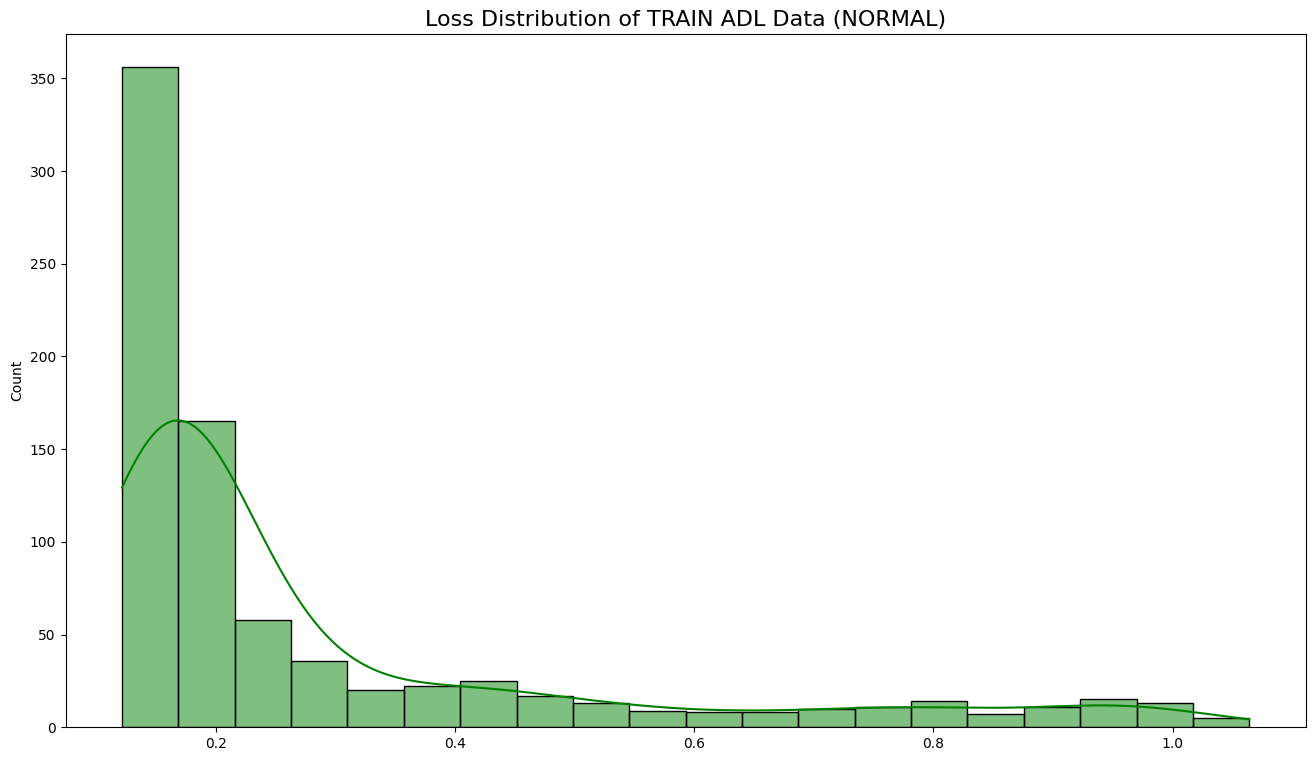

In [53]:
train_dataset = UMAFallDataset(train_data)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE)

train_anomalies, train_scores, _ = detect_anomalies(model, ddpm, train_loader, device)

plt.figure(figsize=(16,9))
plt.title('Loss Distribution of TRAIN ADL Data (NORMAL)', fontsize=16)
sns.histplot(train_scores, bins=20, kde=True, color='green')
plt.show()

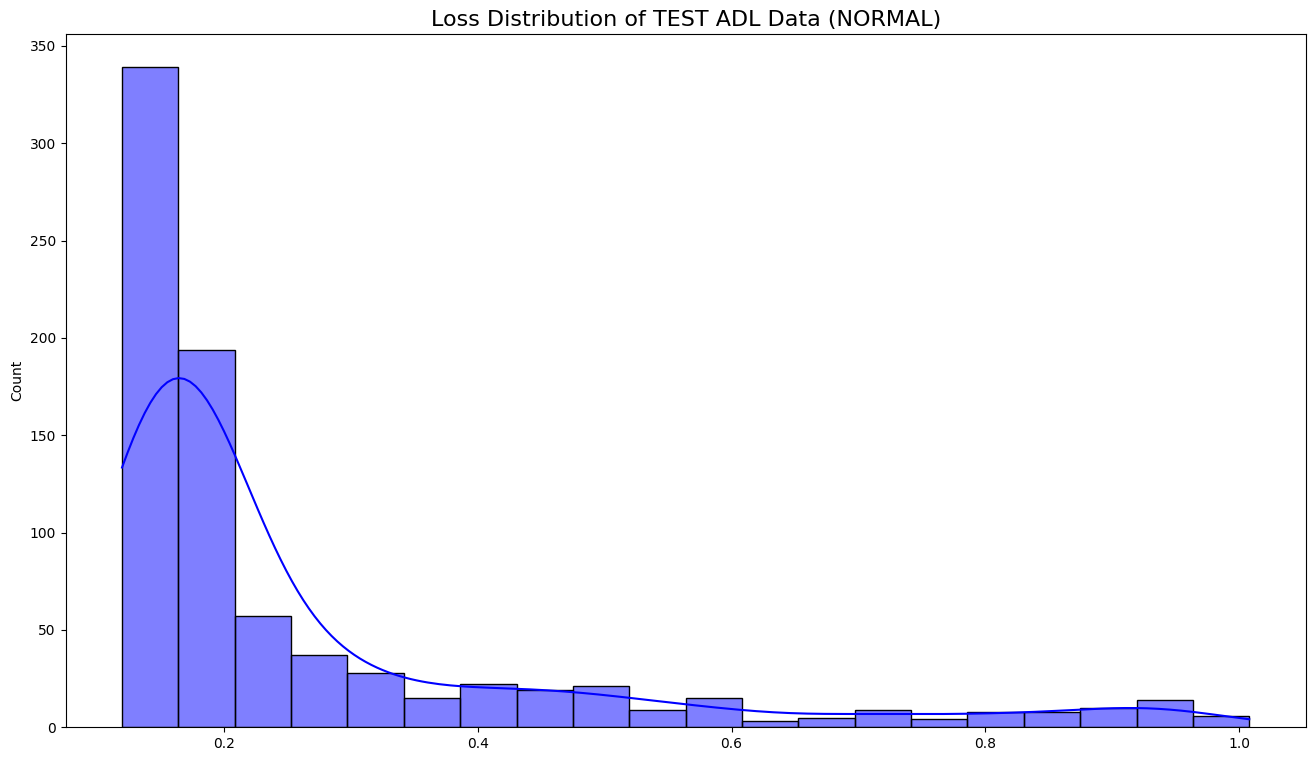

In [54]:
normal_anomalies, normal_scores, _ = detect_anomalies(model, ddpm, normal_loader, device)

plt.figure(figsize=(16,9))
plt.title('Loss Distribution of TEST ADL Data (NORMAL)', fontsize=16)
sns.histplot(normal_scores, bins=20, kde=True, color='blue')
plt.show()

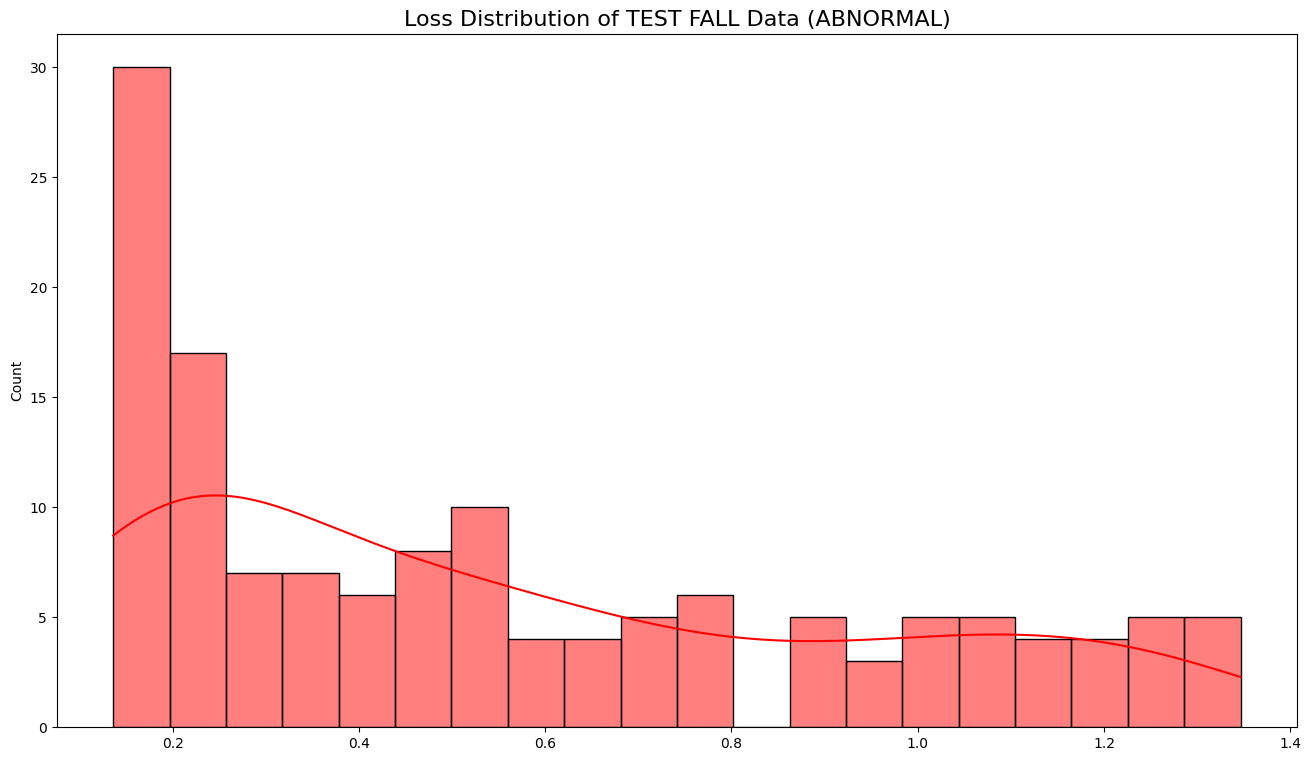

In [55]:
abnormal_anomalies, abnormal_scores, _ = detect_anomalies(model, ddpm, abnormal_loader, device)

plt.figure(figsize=(16,9))
plt.title('Loss Distribution of TEST FALL Data (ABNORMAL)', fontsize=16)
sns.histplot(abnormal_scores, bins=20, kde=True, color='red')
plt.show()

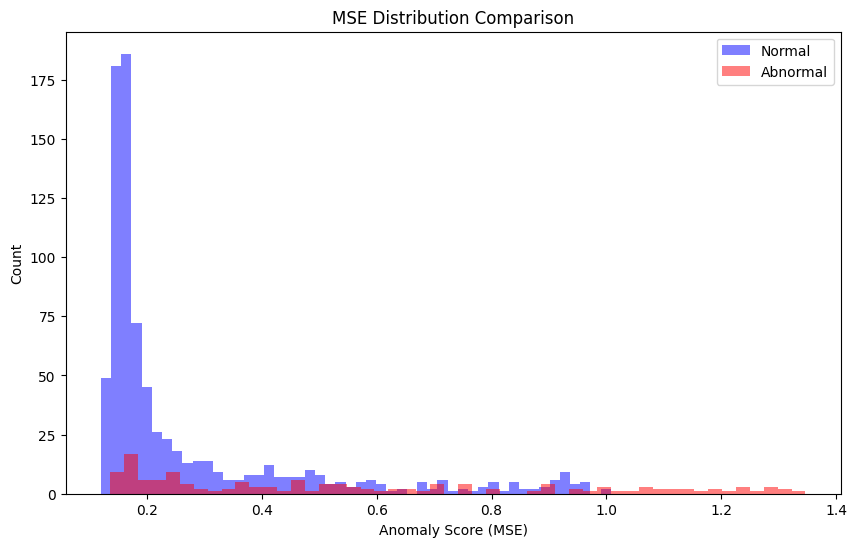

In [56]:
plt.figure(figsize=(10,6))
plt.title('MSE Distribution Comparison')
plt.hist(normal_scores, bins=50, alpha=0.5, color='blue', label='Normal')
plt.hist(abnormal_scores, bins=50, alpha=0.5, color='red', label='Abnormal')
plt.xlabel('Anomaly Score (MSE)')
plt.ylabel('Count')
plt.legend()
plt.show()

In [57]:
error_df = pd.DataFrame({
    'reconstruction_error': np.concatenate([normal_scores, abnormal_scores]),
    'true_class': np.concatenate([np.zeros(len(normal_scores)), np.ones(len(abnormal_scores))])
})

print ("error dataframe head : ")
print(error_df.head(10))
print ()
print ("error dataframe tail : ")
print(error_df.tail(10))
print ()
print(error_df.describe())
print ()
error_df['true_class'].value_counts()

error dataframe head : 
   reconstruction_error  true_class
0              0.137106         0.0
1              0.164120         0.0
2              0.320438         0.0
3              0.584933         0.0
4              0.159548         0.0
5              0.446549         0.0
6              0.148199         0.0
7              0.168944         0.0
8              0.261097         0.0
9              0.715764         0.0

error dataframe tail : 
     reconstruction_error  true_class
953              0.466943         1.0
954              0.167423         1.0
955              0.541977         1.0
956              0.167112         1.0
957              0.141740         1.0
958              0.148573         1.0
959              1.199837         1.0
960              0.370460         1.0
961              0.221707         1.0
962              0.895251         1.0

       reconstruction_error  true_class
count            963.000000  963.000000
mean               0.310040    0.145379
std             

true_class
0.0    823
1.0    140
Name: count, dtype: int64

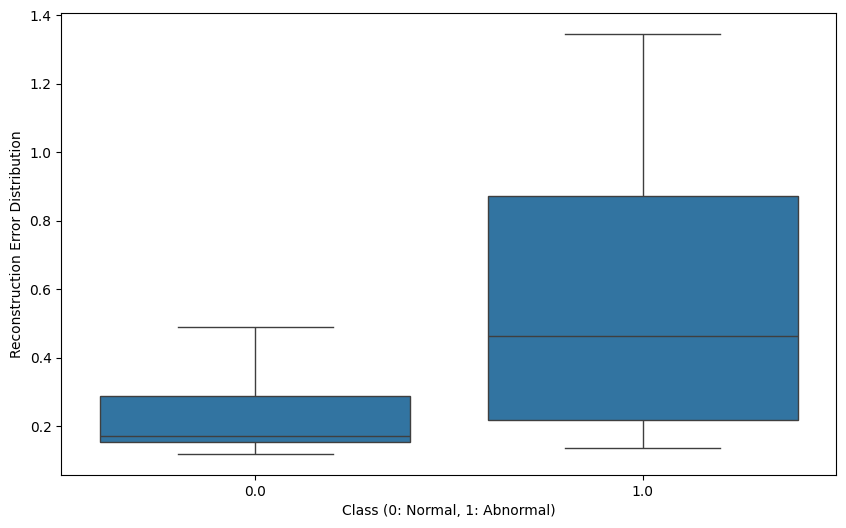

In [58]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='true_class', y='reconstruction_error', data=error_df, showfliers=False)
plt.ylabel('Reconstruction Error Distribution')
plt.xlabel('Class (0: Normal, 1: Abnormal)')
plt.show()

In [63]:
# threshold = np.percentile(normal_scores, 90)
threshold = 0.3

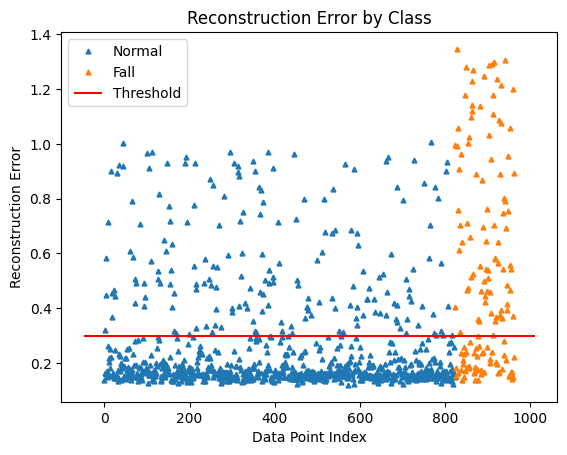

In [64]:
groups = error_df.groupby('true_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.reconstruction_error, marker='^', ms=3.5, linestyle='',
            label="Normal" if name == 0 else "Fall")
ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction Error by Class")
plt.ylabel("Reconstruction Error")
plt.xlabel("Data Point Index")
plt.show()

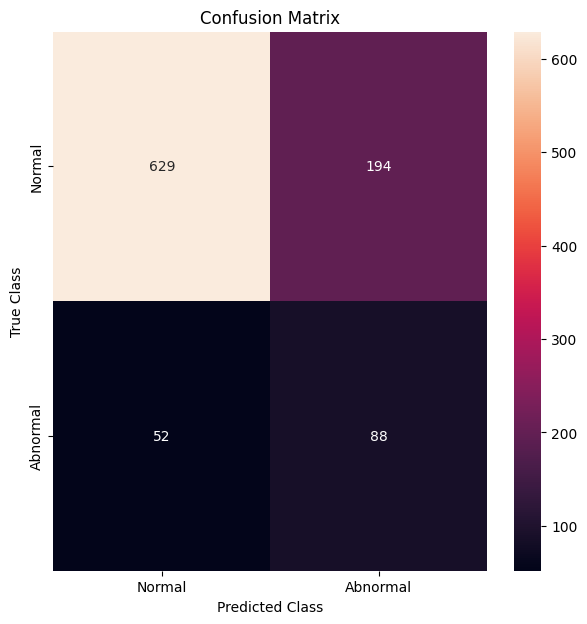

In [65]:
LABELS = ["Normal", "Abnormal"]
y_pred = [1 if e > threshold else 0 for e in error_df.reconstruction_error.values]
conf_matrix = confusion_matrix(error_df.true_class, y_pred)

plt.figure(figsize=(7, 7))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()

In [66]:
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, _ = precision_recall_fscore_support(error_df.true_class, y_pred, average='binary')
accuracy = accuracy_score(error_df.true_class, y_pred)

print('\nPerformance Metrics:')
print(f'Accuracy Score : {accuracy:.4f}')
print(f'Precision     : {precision:.4f}')
print(f'Recall        : {recall:.4f}')
print(f'F1 Score      : {f1:.4f}')


Performance Metrics:
Accuracy Score : 0.7445
Precision     : 0.3121
Recall        : 0.6286
F1 Score      : 0.4171
